## Importing Data & Libraries

In [1]:
import pandas as pd
import regex as re
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Reads all csv's in granular folder
df = pd.DataFrame()
for file in os.listdir('../data/exports/granular/'):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'):
        df = pd.concat([df, pd.read_csv('../data/exports/granular/'+filename)])
    else:
        pass

In [3]:
## Renames addresses where the country is in its full name rather than the 3 letter code
df['end_address'] = [address.replace('United States', 'USA') for address in df['end_address']]
df['end_address'] = [address.replace('Canada', 'CAN') for address in df['end_address']]

In [4]:
## Creates a country column
country = []
for address in df['end_address']:
    if 'USA' in address:
        country.append('USA')
    elif 'CAN' in address:
        country.append('CAN')
    else:
        country.append('Unidentified')
df['country'] = country

In [5]:
## Drops rows where the country isn't USA or CAN
df.drop(df[((df['country'] != 'USA') & (df['country'] != 'CAN'))].index, inplace=True)

## Drops rows where there is no distance data
df.drop(df[df['duration'] == 'Failed'].index, inplace=True)

## Reset Index
df.reset_index(inplace=True, drop=True)

In [6]:
## Creates a state column
state = []
for address in df['end_address']:
    try:
         state.append(re.search('(A[KLRZ]|C[AOT]|D[CE]|FL|GA|HI|I[ADLN]|K[SY]|LA|M[ADEINOST]|N[CDEHJMVY]|O[HKR]'
                                '|P[AR]|RI|S[CD]|T[NX]|UT|V[AIT]|W[AIVY])', address).group(0))
    except:
        state.append('Unidentified')
df['state'] = state

In [7]:
## Resets duration and distance to floats
df['duration'] = df['duration'].astype('float')
df['distance'] = df['distance'].astype('float')

In [8]:
## Reset names as lower case
df['business_name'] = [biz.lower() for biz in df['business_name']]
df['target_name'] = [target.lower() for target in df['target_name']]

## Calculate Swamp Score

In [9]:
## Calculates points for the duration associated with each business address (row)
## There are three points types
## 1) points = a simple 10 minutes (3 points), 20 minute (2 points), 60 minutes (0 points) system
## 2) A gradient point systems spanning from 0 - 3600
## 3) An exponential points system spanning from 0 - 46.656
def calculate_points(df):
    for i, row in df.iterrows():
        if row['duration'] < 600:
            df.loc[i, 'proximity'] = 'close'
            df.loc[i, 'points'] = 3
        elif row['duration'] < 1200:
            df.loc[i, 'proximity'] = 'medium'
            df.loc[i, 'points'] = 2
        elif row['duration'] <= 3600:
            df.loc[i, 'proximity'] = 'far'
            df.loc[i, 'points'] = 1
            df.loc[i, 'gradient_points'] = abs(row['duration'] - 3600)
            df.loc[i, 'exp_points'] = (abs(row['duration'] - 3600) **3) / 1_000_000_000
        else:
            df.loc[i, 'proximity'] = 'over_hour'
            df.loc[i, 'points'] = 0
            df.loc[i, 'gradient_points'] = 0
            df.loc[i, 'exp_points'] = 0
    return df

In [84]:
## Calculates a swamp score for each start address based on the points for all associated businesses
def calculate_swamp_score(df):
    iter_address = set(df['start_address'])
    swamp_df = pd.DataFrame()
    for i, i_address in enumerate(iter_address):
        swamp_df.loc[i,'start_address'] = i_address
        swamp_df.loc[i,'state'] = re.search('(A[KLRZ]|C[AOT]|D[CE]|FL|GA|HI|I[ADLN]|K[SY]|LA|M[ADEINOST]'
            '|N[CDEHJMVY]|O[HKR]|P[AR]|RI|S[CD]|T[NX]|UT|V[AIT]|W[AIVY])', i_address).group(0)
        
        
        conv_store_points = df[df['start_address'] == i_address].groupby('label').sum()['points']['conv_store']
        swamp_df.loc[i,'conv_store_points'] = conv_store_points
        
        fast_food_points = df[df['start_address'] == i_address].groupby('label').sum()['points']['fast_food_rest']
        swamp_df.loc[i,'fast_food_points'] = fast_food_points
        
        groc_store_points = df[df['start_address'] == i_address].groupby('label').sum()['points']['groc_store']
        swamp_df.loc[i,'groc_store_points'] = groc_store_points
        
        swamp_df.loc[i, 'swamp_score'] = (conv_store_points + fast_food_points) / groc_store_points
        
        
        conv_store_grad_points = df[df['start_address'] == i_address].groupby('label')\
            .sum()['gradient_points']['conv_store']
        swamp_df.loc[i,'conv_store_grad_points'] = conv_store_grad_points
        fast_food_grad_points = df[df['start_address'] == i_address].groupby('label')\
            .sum()['gradient_points']['fast_food_rest']
        swamp_df.loc[i,'fast_food_grad_points'] = fast_food_grad_points
        groc_store_grad_points = df[df['start_address'] == i_address]\
            .groupby('label').sum()['gradient_points']['groc_store']
        swamp_df.loc[i,'groc_store_grad_points'] = groc_store_points
        swamp_df.loc[i, 'grad_swamp_score'] = (conv_store_grad_points + fast_food_grad_points)\
            / groc_store_grad_points
        
        conv_store_exp_points = df[df['start_address'] == i_address].groupby('label')\
            .sum()['exp_points']['conv_store']
        swamp_df.loc[i,'conv_store_exp_points'] = conv_store_exp_points
        fast_food_exp_points = df[df['start_address'] == i_address].groupby('label')\
            .sum()['exp_points']['fast_food_rest']
        swamp_df.loc[i,'fast_food_exp_points'] = fast_food_exp_points
        groc_store_exp_points = df[df['start_address'] == i_address]\
            .groupby('label').sum()['exp_points']['groc_store']
        swamp_df.loc[i,'groc_store_exp_points'] = groc_store_points
        swamp_df.loc[i, 'exp_swamp_score'] = (conv_store_exp_points + fast_food_exp_points)\
            / groc_store_exp_points
        
    return swamp_df

In [65]:
## Running the points for each travel duration time
df = calculate_points(df)

In [85]:
## Calculating the swamp score for each start address
swamp_df = calculate_swamp_score(df)

In [86]:
swamp_df.head()

,start_address,state,conv_store_points,fast_food_points,groc_store_points,swamp_score,conv_store_grad_points,fast_food_grad_points,groc_store_grad_points,grad_swamp_score,conv_store_exp_points,fast_food_exp_points,groc_store_exp_points,exp_swamp_score
0,482-S-Lincoln-St-Denver-CO,CO,164.0,1519.0,406.0,4.145320,213879.0,2280075.0,406.0,4.511592,1812.725619,14843.358689,406.0,4.175409
1,402-Arrawanna-St-Colorado-Springs-CO,CO,330.0,745.0,297.0,3.619529,402587.0,987293.0,297.0,3.530643,3444.210229,7497.090553,297.0,3.536428
2,3481-Thornbury-Ln-Bonita-Springs-FL,FL,132.0,400.0,177.0,3.005650,193326.0,569328.0,177.0,3.204981,962.963879,2610.464748,177.0,2.371114
3,167-Cedar-Lane-Ossining-NY,NY,78.0,807.0,182.0,4.862637,85965.0,979484.0,182.0,5.182800,318.848145,3449.867776,182.0,4.214692
4,1850-Chestnut-Place-Denver-CO-80205,CO,454.0,1657.0,560.0,3.769643,600558.0,2357327.0,560.0,3.803659,4754.248518,15865.194308,560.0,3.695813


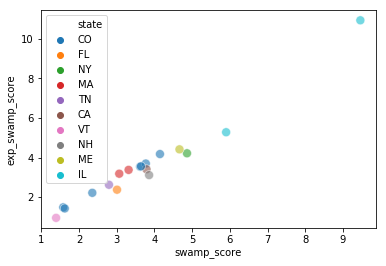

In [89]:
sns.scatterplot(swamp_df['swamp_score'],swamp_df['exp_swamp_score'],
                hue = swamp_df['state'], alpha=.6, s=80);

In [91]:
swamp_df[['start_address','swamp_score','grad_swamp_score','exp_swamp_score']].head()

,start_address,swamp_score,grad_swamp_score,exp_swamp_score
0,482-S-Lincoln-St-Denver-CO,4.145320,4.511592,4.175409
1,402-Arrawanna-St-Colorado-Springs-CO,3.619529,3.530643,3.536428
2,3481-Thornbury-Ln-Bonita-Springs-FL,3.005650,3.204981,2.371114
3,167-Cedar-Lane-Ossining-NY,4.862637,5.182800,4.214692
4,1850-Chestnut-Place-Denver-CO-80205,3.769643,3.803659,3.695813


## Swamp Scores with Filtered Data

In [92]:
## New dataframe for cleaning mismatched business & target names
df_clean = df

In [93]:
## Cleaning labels to more appropriately fit with the intended search term
df_clean['business_name'].replace({
    'subway restaurants' : 'subway',
    "dunkin'" : "dunkin donuts",
    "pizza hut express" : "pizza hut",
    "pizza hut®" : "pizza hut",
    "domino's pizza" : "domino's",
    "dominos" : "domino's",
    "baskin robbins" : "baskin-robbins",
    "baskin-robbins kingston" : "baskin-robbins",
    "dairy queen (treat)" : "dairy queen",
    "dairy queen (treat only)" : "dairy queen",
    "dairy queen store" : "dairy queen",
    "dairy queen ltd brazier" : "dairy queen",
    "dairy queen (limited brazier)" : "dairy queen",
    "dairy queen grill & chill" : "dairy queen",
    "dairy queen grill & chill restaurant" : "dairy queen",
    "dairy queen / orange julius" : "dairy queen",
    "dairy queen / orange julius treat center" : "dairy queen",
    "dairy queen/orange julius treat ctr" : "dairy queen",
    "dq / orange julius" : "dairy queen",
    "little caesars pizza" : "little caesars",
    "little caesers" : "little caesars",
    "cosentino's price chopper" : "price chopper",
    "price chopper pharmacy" : "price chopper",
    "wegman's nursery" : "wegmans",
    "wegmans natick" : "wegmans",
    "hannaford supermarket" : "hannaford",
    "hannaford pharmacy" : "hannaford",
    "chipotle mexican grill" : "chipotle",
    "chick-fil-a broadway & dartmouth" : "chick-fil-a",
    "jersey mike's" : "jersey mike's subs",
    "jersey mike’s subs" : "jersey mike's subs",
    "7 eleven" : '7-eleven',
    "casey's general store" :  "casey’s general store",
    "express mart convenience store" : "express mart",
    "express mart inc" : "express mart",
    "stripes" : "stripes convenience",
    "stripes convenience store" : "stripes convenience",
    "stripes gas station" : "stripes convenience",
    "stripes 7075" : "stripes convenience",
    "safeway bakery" : "safeway",
    "safeway pharmacy" : "safeway",
    "safeway dawson road" : "safeway",
    "safeway liquor" : "safeway",
    "safeway community markets" : "safeway",
    "king soopers pharmacy" : "king soopers",
    "king soopers marketplace" : "king soopers",
    "whole foods market" : "whole foods",
    "whole foods market 365": "whole foods",
    "whole foods - 788 harrison street" : "whole foods",
    "wholefood" : "whole foods",
    "limon stop & shop supermarket" : "stop & shop",
    "flagler stop & shop supermarket" : "stop & shop",
    "stop & shop pharmacy" : "stop & shop",
    "stop n shop" : "stop & shop",
    "super stop & shop" : "stop & shop",
    "stop'n shop" : "stop & shop",
    "stop & shop supermarket" : "stop & shop",
    "stop & shop market" : "stop & shop",
    "stop - n - shop" : "stop & shop",
    "hunt brother's pizza" : "hunt brothers pizza",
    "hunt brothers pizza - n union st" : "hunt brothers pizza",
    "hunt brothers pizaa" : "hunt brothers pizza",
    "popeyes® louisiana kitchen" : "popeyes louisiana kitchen",
    "jimmy john’s" : "jimmy john's",
    "starbucks reserve" : "starbucks",
    "albertsons market" : "albertsons",
    "pete's fresh market" : "pete’s fresh market",
    "kroger deli" : "kroger",
    "kroger bakery" : "kroger",
    "public" : "publix"
}, inplace=True)

In [94]:
## Specific code to handle publix's google maps naming convention
for i, row in df_clean.iterrows():
    if "publix super market at" in row['business_name']:
        df_clean.loc[i, 'business_name'] = 'publix'

In [97]:
## Renaming target search name
df_clean['target_name'].replace({
    "traders joe's" : "trader joe's",
    "bojangles' famous chicken 'n biscuit'" : "bojangles' famous chicken 'n biscuits"
}, inplace=True)

In [95]:
## Code to search for mismatches between target name and business name
df_clean[(df_clean['state'] == 'FL') & (df_clean['business_name'] != df_clean['target_name'])\
         & (df['label'] == 'groc_store')].loc[3247:,:]

,business_name,target_name,label,business_types,google_place_id,rating,user_ratings_total,end_address,latitude,longitude,pull_date,duration,distance,start_address,country,state,proximity,points,gradient_points,exp_points
4833,starbucks,safeway,groc_store,"cafe, store, point_of_interest, food, establis...",ChIJNe88_LsZ24gRpdvPLw4gcy8,4.3,236,"27250 Bay Landing Dr, Bonita Springs, FL 34135...",26.343885,-81.806585,2019-05-15,435.0,2749.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,close,3.0,3165.0,31.704517
4834,safe way traction,safeway,groc_store,"point_of_interest, establishment",ChIJf7eX5F1aDogRj5fTL3Vr1Oo,0,0,"2271 Bruner Ln Unit 6, Fort Myers, FL 33912, USA",26.533488,-81.858250,2019-05-15,1792.0,26341.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1808.0,5.910106
4840,soldae natural health,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJu_rGHLsZ24gROkLpmO7Bx4o,0,0,"23680 Walden Unit 303, Riverview Center Blvd, ...",26.340570,-81.808529,2019-05-15,367.0,2956.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,close,3.0,3233.0,33.792250
4841,mother earth natural foods,natural grocers,groc_store,"grocery_or_supermarket, store, health, point_o...",ChIJRVnBUdg-24gRmBM-z9Z8IyY,4.1,12,"15271-7 McGregor Boulevard, Fort Myers, FL 339...",26.520198,-81.939487,2019-05-15,2181.0,31804.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1419.0,2.857243
4842,organic food brokers,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJbfqUCITua4cRiXEoyabcXf0,0,0,"28411 Race Track Rd, Bonita Springs, FL 34135,...",26.322830,-81.774168,2019-05-15,764.0,7945.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,medium,2.0,2836.0,22.809653
4843,mother earth natural foods,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJKTUhKTlA24gRqVw5nUSEFOY,4.5,19,"4600 Summerlin Rd C10, Fort Myers, FL 33919, USA",26.595218,-81.885248,2019-05-15,2396.0,35032.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1204.0,1.745338
4844,mother earth natural foods,natural grocers,groc_store,"grocery_or_supermarket, store, health, point_o...",ChIJCZ-yQ44V24gRHbcI791gF04,4.5,8,"16520 S Tamiami Trail, Fort Myers, FL 33908, USA",26.500785,-81.857544,2019-05-15,1471.0,21014.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,2129.0,9.649993
4845,vr laboratories llc,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJ1XBNHKcZ24gRapBjyQViF2E,0,0,"3301 Bonita Beach Rd SW # 315, Bonita Springs,...",26.329824,-81.807927,2019-05-15,510.0,4438.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,close,3.0,3090.0,29.503629
4846,organic farm market,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJe7UNb-jh2ogRvEwEr603G-4,5,4,"2132 Tamiami Trail N, Naples, FL 34103, USA",26.172742,-81.798624,2019-05-15,1692.0,21625.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1908.0,6.946005
4847,ada's natural market,natural grocers,groc_store,"grocery_or_supermarket, store, point_of_intere...",ChIJMcFg-SNA24gRn4bupwJxCmY,4.1,309,"7070 College Pkwy, Fort Myers, FL 33907, USA",26.557489,-81.873368,2019-05-15,1939.0,27615.0,3481-Thornbury-Ln-Bonita-Springs-FL,USA,FL,far,1.0,1661.0,4.582568


In [96]:
## Code to summarize mismatches between target name and business name
df_clean[(df_clean['business_name'] != df_clean['target_name']) & (df_clean['business_name'] != 'dunkin donuts')\
        & (df_clean['state'] == 'FL')]\
    .groupby('business_name').count().sort_values('target_name', ascending=False)

,target_name,label,business_types,google_place_id,rating,user_ratings_total,end_address,latitude,longitude,pull_date,duration,distance,start_address,country,state,proximity,points,gradient_points,exp_points
business_name,,,,,,,,,,,,,,,,,,,
publix super market on bayshore,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
atm (cumberland farms),8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
publix super market market square,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
"fast stop, hunt brothers pizza, laundromat",5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
mother earth natural foods,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
bojangles' famous chicken 'n biscuits,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
atm (fifth third bank),4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
the fresh market,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
kangaroo express,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [98]:
## Dropping mismatches
df_clean = df.drop(df_clean[(df_clean['business_name'] != df_clean['target_name'])\
                            & (df_clean['business_name'] != 'dunkin donuts')].index)
df_clean.reset_index(inplace=True, drop=True)

In [101]:
## Creating dataframe for swamp scores using the cleaned set of duration travel times
swamp_df_clean = calculate_swamp_score(df_clean)

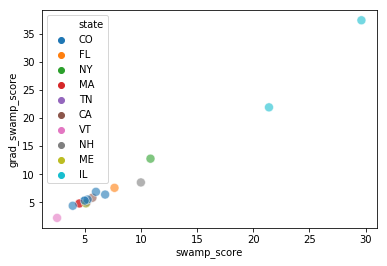

In [102]:
sns.scatterplot(swamp_df_clean['swamp_score'],swamp_df_clean['grad_swamp_score'],
                hue = swamp_df_clean['state'], alpha=.6, s=80);

In [104]:
swamp_df_clean[['start_address','swamp_score','grad_swamp_score', 'exp_swamp_score']].head()

,start_address,swamp_score,grad_swamp_score,exp_swamp_score
0,482-S-Lincoln-St-Denver-CO,4.933754,5.260530,5.055474
1,402-Arrawanna-St-Colorado-Springs-CO,6.818182,6.393735,6.897398
2,3481-Thornbury-Ln-Bonita-Springs-FL,7.650794,7.583805,7.359666
3,167-Cedar-Lane-Ossining-NY,10.855263,12.765856,13.697659
4,1850-Chestnut-Place-Denver-CO-80205,5.076923,4.899656,5.190651


## Combining Swamp Score tables

In [105]:
## Combining dataframes for easier comparisons
combined_swamp_df = pd.merge(swamp_df, swamp_df_clean, how='inner', on='start_address', suffixes=('', '_clean'))

In [114]:
## Reviewing smap values –– exp swamp score is set as order as it is the current favorite
combined_swamp_df[['start_address','state','swamp_score','grad_swamp_score','swamp_score_clean',
    'grad_swamp_score_clean', 'exp_swamp_score', 'exp_swamp_score_clean']].sort_values('state')\
    .sort_values('exp_swamp_score', ascending=False)

,start_address,state,swamp_score,grad_swamp_score,swamp_score_clean,grad_swamp_score_clean,exp_swamp_score,exp_swamp_score_clean
16,352-arquilla-ct-bloomingdale-IL,IL,9.463277,10.771504,29.629630,37.358385,10.942686,65.759353
17,1931-N-Fremont-St-Chicago-IL-60614,IL,5.901274,6.162289,21.402597,21.887584,5.279467,23.793728
11,12-Iris-Dr-Scarborough-ME,ME,4.663265,4.359375,5.114754,4.815441,4.413778,4.933260
3,167-Cedar-Lane-Ossining-NY,NY,4.862637,5.182800,10.855263,12.765856,4.214692,13.697659
0,482-S-Lincoln-St-Denver-CO,CO,4.145320,4.511592,4.933754,5.260530,4.175409,5.055474
4,1850-Chestnut-Place-Denver-CO-80205,CO,3.769643,3.803659,5.076923,4.899656,3.695813,5.190651
12,410-Delaware-St-Denver-CO,CO,3.641791,4.002861,5.261745,5.512087,3.554879,5.311987
1,402-Arrawanna-St-Colorado-Springs-CO,CO,3.619529,3.530643,6.818182,6.393735,3.536428,6.897398
8,351-California-St-Ste-450-San-Francisco-CA,CA,3.788136,3.808821,5.686170,5.828229,3.406040,5.684669
5,49-South-St-Natick-MA,MA,3.313008,3.427226,4.526946,4.810532,3.373781,5.930574


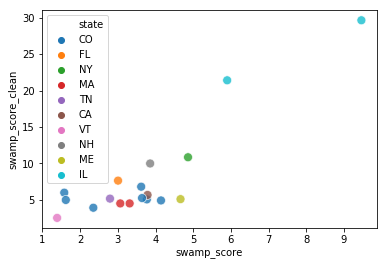

In [61]:
sns.scatterplot(combined_swamp_df['swamp_score'],combined_swamp_df['swamp_score_clean'],
                hue = combined_swamp_df['state'], alpha=.8, s=80);

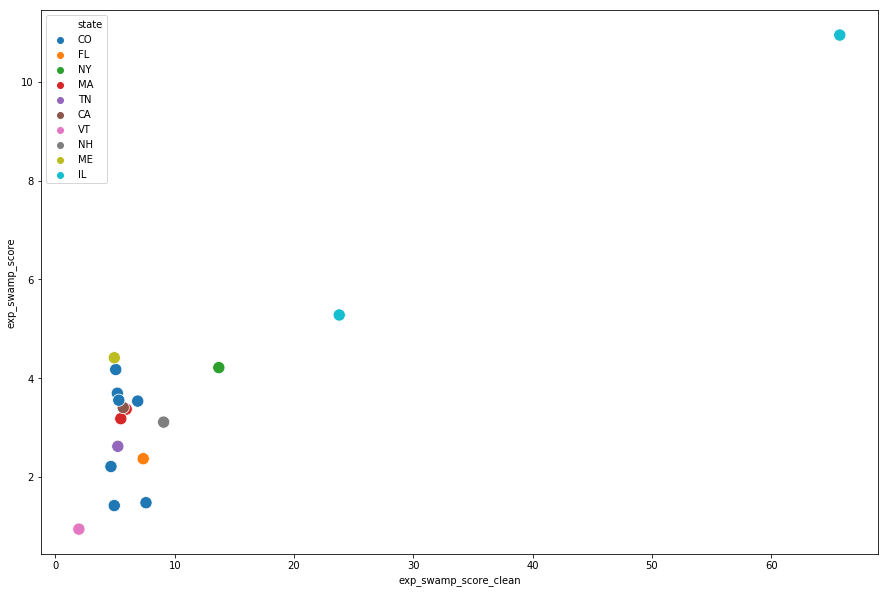

In [116]:
plt.figure(figsize=(15,10))
sns.scatterplot(combined_swamp_df['exp_swamp_score_clean'],combined_swamp_df['exp_swamp_score'],
                hue = combined_swamp_df['state'], alpha=1, s=150);

## Data Exports

In [117]:
###### Removed to adhere to Google's terms of service -- no caching business data ######
## All of the data collected for all of the data pulls
# df.to_csv('../data/exports/granular_master.csv', index=False)

# ## Cleaned data collected for all of the pulls
# df_clean.to_csv('../data/exports/granular_master_clean.csv', index=False)

# ## Only the buisnesses pulled
# df_business_master = df.drop_duplicates(subset='end_address', keep='last')
# df_business_master = df_business_master.drop(columns=['start_address', 'duration', 'distance',
#                                  'proximity', 'points', 'gradient_points'])
# df_business_master.reset_index(inplace=True, drop=True)
# df_business_master.to_csv('../data/exports/business_master.csv', index=False)
###### Removed to adhere to Google's terms of service -- no caching business data ######

## Swamp score data
combined_swamp_df.to_csv('../data/exports/combined_swamp.csv', index=False)